In [279]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import glob
from PIL import Image
import random
import numpy as np
import torchvision
from tqdm import tqdm
import os
import cv2
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size = 3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = out_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = out_channels, out_channels = out_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def expansive_block(self, in_channels, mid_channels, out_channels, kernel_size = 3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = mid_channels, padding = 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channels, out_channels = mid_channels, padding = 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channels, out_channels = out_channels, padding = 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding = 1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding = 1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=3),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Softmax(dim = 1)
                    )
            return  block
        
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        
        # Encode
        self.conv_encode1 = self.contracting_block(in_channels = in_channel, out_channels = 64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size = 2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size = 2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size = 2)
        
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size = 3, in_channels = 256, out_channels = 512, padding = 1),
                                torch.nn.ReLU(),
                                torch.nn.BatchNorm2d(512),
                                torch.nn.Conv2d(kernel_size = 3, in_channels = 512, out_channels = 512, padding = 1),
                                torch.nn.ReLU(),
                                torch.nn.BatchNorm2d(512),
                                torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1, stride = 1)
                            )
        
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop = False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2])
            upsampled = F.pad(upsampled, (int(c/2), int(c/2), int(c/2), int(c/2)))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        
        return  final_layer

# Setting - 1

In [44]:
# # Create targets

# files = glob.glob('/home/vinayak/RnD/Cervix/CI_Segmentation-s1/*')
# c = 0
# for file in files:
#     c += 1
#     print(c)
#     name = file.split('/')[-1].split('.')[0]
#     img = cv2.imread(file)
#     img = np.array(img)
#     out = np.zeros((img.shape[0], img.shape[1]))
#     for i in range(img.shape[0]):
#             for j in range(img.shape[1]):
#                 # Red
#                 if img[i][j][0] == 255 and img[i][j][1] == 0 and img[i][j][2] == 0:
#                     out[i][j] = 1

#                 # Green
#                 elif img[i][j][0] == 0 and img[i][j][1] == 128 and img[i][j][2] == 0:
#                     out[i][j] = 0

#                 # Purple
#                 elif img[i][j][0] == 128 and img[i][j][1] == 0 and img[i][j][2] == 128:
#                     out[i][j] = 1

#                 # Brown
#                 elif img[i][j][0] == 51 and img[i][j][1] == 64 and img[i][j][2] == 92:
#                     out[i][j] = 2

#                 # Pink
#                 elif img[i][j][0] == 203 and img[i][j][1] == 192 and img[i][j][2] == 255:
#                     out[i][j] = 2

#                 # Gray
#                 elif img[i][j][0] == 169 and img[i][j][1] == 169 and img[i][j][2] == 169:
#                     out[i][j] = 2
                    
#                 else:
#                     out[i][j] = 3

#     os.chdir('/home/vinayak/RnD/Cervix/s1-target/')
#     out = np.array(out)
#     np.save(name, out)
#     os.chdir('/home/vinayak/RnD/Cervix/')

In [45]:
# input_img = glob.glob('Cropped Images/*')
# inputs = []
# labels_s1 = []
# c = 0
# for i in input_img:
#     c += 1
#     print(c)
#     name = i.split('/')[-1].split('.')[0]
#     img = np.array(cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB))
#     inputs.append(img)
#     lab = np.load('s1-target/' + name + '.npy')
#     labels_s1.append(lab)

In [46]:
# labels_s1 = np.array(labels_s1)
# inputs = np.array(inputs)

In [47]:
# np.save('label-s1', labels_s1)
# np.save('input', inputs)

In [48]:
labels_s1 = np.load('label-s1.npy')
inputs = np.load('input.npy')

In [49]:
# n = inputs.shape[0]
# sample = random.sample(range(0, n), n)
# sample = np.array(sample)
# np.save('sample', sample)

In [51]:
sample = np.load('sample.npy')
train = sample[:608]
val = sample[608:800]
test = sample[800:]

In [70]:
criterion = torch.nn.CrossEntropyLoss(reduction = 'mean')
unet_s1 = UNet(in_channel = 3, out_channel = 4)
optimizer = torch.optim.SGD(unet_s1.parameters(), lr = 0.01, momentum = 0.9)
unet_s1 = nn.DataParallel(unet_s1)
unet_s1.to("cuda")

DataParallel(
  (module): UNet(
    (conv_encode1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode

In [71]:
epochs = 100
batch_size = 16
total_batches = train.shape[0] // batch_size

history_s1 = []
dev_history_s1 = []
device = "cuda"

for k in range(1, epochs + 1):
    total_loss = 0
    dev_total_loss = 0
    c = 0
    for i in tqdm(range(1, total_batches + 1), "Epoch is running :"):
      
      optimizer.zero_grad() 
        
      # Creating input and label for both training and validation set
      inp = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
      label = np.zeros((batch_size, labels_s1.shape[1], labels_s1.shape[2]))
      for b in range(batch_size):
            inp[b] = inputs[train[c]]
            label[b] = labels_s1[train[c]]
            c += 1
            
      inp = torch.from_numpy(inp)
      inp = inp.permute(0, 3, 1, 2).float().to(device)
      label = torch.from_numpy(label)
        
      # Generating outputs  
      outputs = unet_s1(inp)
    
      # outputs = torch.argmax(outputs, dim = 1)
      # outputs = F.one_hot(outputs, num_classes = 4)
    
      outputs = outputs.float().to(device)
      label = label.type(torch.LongTensor).to(device)
        
      # Calculating loss
      loss = criterion(outputs, label)
    
      total_loss += float(loss.item())
        
      loss.backward()
      optimizer.step()
        
    total_loss /= total_batches
    
    history_s1.append(total_loss)
    
    # Calculate validation loss
    c1 = 0
    total_dev_loss = 0
    for v in range(1, val.shape[0] // batch_size + 1):
        dev_input = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
        dev_label = np.zeros((batch_size, labels_s1.shape[1], labels_s1.shape[2]))
        for b in range(batch_size):
            dev_input[b] = inputs[val[c1]]
            dev_label[b] = labels_s1[val[c1]]
            c1 += 1
            
        dev_input = torch.from_numpy(dev_input)
        dev_input = dev_input.permute(0, 3, 1, 2).float().to(device)
        dev_label = torch.from_numpy(dev_label)
        
        dev_output = unet_s1(dev_input)
        dev_output = dev_output.float().to(device)
        dev_label = dev_label.type(torch.LongTensor).to(device)
        
        dev_loss = criterion(dev_output, dev_label)
    
        total_dev_loss += float(dev_loss.item())
    
    total_dev_loss /= batch_size
    dev_history_s1.append(total_dev_loss)
    
    # Print details
    print('Epoch : ' + str(k) +  ' / ' + str(epochs) + ', Loss : ' + str(total_loss)
         + ', Validation Loss : ' + str(total_dev_loss))

Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.81it/s]

Epoch : 1 / 100, Loss : 1.279216810276634, Validation Loss : 0.8785984516143799


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.33it/s]

Epoch : 2 / 100, Loss : 1.1065671255714016, Validation Loss : 0.7844259664416313


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.32it/s]

Epoch : 3 / 100, Loss : 0.9991138718630138, Validation Loss : 0.7176945321261883


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.24it/s]

Epoch : 4 / 100, Loss : 0.9253893886741839, Validation Loss : 0.6737129911780357


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.21it/s]

Epoch : 5 / 100, Loss : 0.878833061770389, Validation Loss : 0.6466157250106335


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.11it/s]

Epoch : 6 / 100, Loss : 0.8505455867240304, Validation Loss : 0.6301188170909882


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.16it/s]

Epoch : 7 / 100, Loss : 0.8357095028224745, Validation Loss : 0.6359392069280148


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.71it/s]

Epoch : 8 / 100, Loss : 0.8287780912298905, Validation Loss : 0.6128079667687416


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.87it/s]

Epoch : 9 / 100, Loss : 0.8148543520977622, Validation Loss : 0.6075695604085922


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.68it/s]

Epoch : 10 / 100, Loss : 0.8065494800868788, Validation Loss : 0.6018557921051979


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.07it/s]

Epoch : 11 / 100, Loss : 0.8015623500472621, Validation Loss : 0.5981808751821518


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.12it/s]

Epoch : 12 / 100, Loss : 0.7979867866164759, Validation Loss : 0.5961417928338051


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.99it/s]

Epoch : 13 / 100, Loss : 0.795370804636102, Validation Loss : 0.5938472896814346


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.92it/s]

Epoch : 14 / 100, Loss : 0.7919035616673922, Validation Loss : 0.5920159444212914


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.12it/s]

Epoch : 15 / 100, Loss : 0.7890483156630868, Validation Loss : 0.5909012518823147


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.25it/s]

Epoch : 16 / 100, Loss : 0.7880675416243704, Validation Loss : 0.5890683308243752


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.94it/s]

Epoch : 17 / 100, Loss : 0.7869706859714106, Validation Loss : 0.5888877138495445


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.83it/s]

Epoch : 18 / 100, Loss : 0.7859518386815724, Validation Loss : 0.5878848358988762


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.49it/s]

Epoch : 19 / 100, Loss : 0.784914664532009, Validation Loss : 0.5874486938118935


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.89it/s]

Epoch : 20 / 100, Loss : 0.7837620597136649, Validation Loss : 0.5868444927036762


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.40it/s]

Epoch : 21 / 100, Loss : 0.7832709597913843, Validation Loss : 0.586396761238575


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.68it/s]

Epoch : 22 / 100, Loss : 0.7833512315624639, Validation Loss : 0.5852393768727779


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.96it/s]

Epoch : 23 / 100, Loss : 0.7817175686359406, Validation Loss : 0.5862715691328049


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.73it/s]

Epoch : 24 / 100, Loss : 0.7812466401802866, Validation Loss : 0.5841710790991783


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.81it/s]

Epoch : 25 / 100, Loss : 0.7807466528917614, Validation Loss : 0.5843877270817757


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.40it/s]

Epoch : 26 / 100, Loss : 0.7799611515120456, Validation Loss : 0.5836827345192432


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.01it/s]

Epoch : 27 / 100, Loss : 0.77872171527461, Validation Loss : 0.5829212963581085


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.78it/s]

Epoch : 28 / 100, Loss : 0.7782843050203825, Validation Loss : 0.5827406235039234


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.02it/s]

Epoch : 29 / 100, Loss : 0.7777546079535234, Validation Loss : 0.5848711095750332


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.90it/s]

Epoch : 30 / 100, Loss : 0.7788759375873365, Validation Loss : 0.5824880562722683


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.75it/s]

Epoch : 31 / 100, Loss : 0.7767860732580486, Validation Loss : 0.581512950360775


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.66it/s]

Epoch : 32 / 100, Loss : 0.7770054967779862, Validation Loss : 0.5824266746640205


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.93it/s]

Epoch : 33 / 100, Loss : 0.7763000224765978, Validation Loss : 0.5811403654515743


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.05it/s]

Epoch : 34 / 100, Loss : 0.7766967776574587, Validation Loss : 0.5814015939831734


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.02it/s]

Epoch : 35 / 100, Loss : 0.7760181050551566, Validation Loss : 0.58163757994771


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.88it/s]

Epoch : 36 / 100, Loss : 0.7756764904448861, Validation Loss : 0.580604437738657


Epoch is running ::   3%|▎         | 1/38 [00:00<00:06,  6.15it/s]

Epoch : 37 / 100, Loss : 0.7768215176306272, Validation Loss : 0.5812575817108154


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.98it/s]

Epoch : 38 / 100, Loss : 0.7754233197162026, Validation Loss : 0.5807077512145042


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.79it/s]

Epoch : 39 / 100, Loss : 0.7755879728417647, Validation Loss : 0.580510389059782


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.13it/s]

Epoch : 40 / 100, Loss : 0.7791903787537625, Validation Loss : 0.5827153325080872


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.39it/s]

Epoch : 41 / 100, Loss : 0.7779620744680104, Validation Loss : 0.5818062908947468


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.90it/s]

Epoch : 42 / 100, Loss : 0.7770166977455741, Validation Loss : 0.581077303737402


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.27it/s]

Epoch : 43 / 100, Loss : 0.7763508542587882, Validation Loss : 0.580649845302105


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.23it/s]

Epoch : 44 / 100, Loss : 0.7758221736079768, Validation Loss : 0.5803985521197319


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.97it/s]

Epoch : 45 / 100, Loss : 0.775334756625326, Validation Loss : 0.5802673697471619


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.81it/s]

Epoch : 46 / 100, Loss : 0.7750322144282492, Validation Loss : 0.5799569301307201


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.14it/s]

Epoch : 47 / 100, Loss : 0.7747228474993455, Validation Loss : 0.5798478238284588


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.05it/s]

Epoch : 48 / 100, Loss : 0.7745645359942788, Validation Loss : 0.5799049399793148


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.23it/s]

Epoch : 49 / 100, Loss : 0.7742855486116911, Validation Loss : 0.5796688757836819


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.81it/s]

Epoch : 50 / 100, Loss : 0.7738528800638098, Validation Loss : 0.5795125216245651


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.99it/s]

Epoch : 51 / 100, Loss : 0.7734856825125845, Validation Loss : 0.5793600529432297


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.35it/s]

Epoch : 52 / 100, Loss : 0.773525092162584, Validation Loss : 0.5791912227869034


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.77it/s]

Epoch : 53 / 100, Loss : 0.7733511265955473, Validation Loss : 0.5791226252913475


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.08it/s]

Epoch : 54 / 100, Loss : 0.7731013831339384, Validation Loss : 0.5790668651461601


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.79it/s]

Epoch : 55 / 100, Loss : 0.7731246948242188, Validation Loss : 0.5788578391075134


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.53it/s]

Epoch : 56 / 100, Loss : 0.7729881688168174, Validation Loss : 0.5789916068315506


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.92it/s]

Epoch : 57 / 100, Loss : 0.7730215207526558, Validation Loss : 0.5789248906075954


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.68it/s]

Epoch : 58 / 100, Loss : 0.7724057984979529, Validation Loss : 0.5787329748272896


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.57it/s]

Epoch : 59 / 100, Loss : 0.771994882508328, Validation Loss : 0.5786347836256027


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.68it/s]

Epoch : 60 / 100, Loss : 0.7719383365229556, Validation Loss : 0.5784810148179531


Epoch is running ::   3%|▎         | 1/38 [00:00<00:06,  6.13it/s]

Epoch : 61 / 100, Loss : 0.771709343320445, Validation Loss : 0.578437864780426


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.86it/s]

Epoch : 62 / 100, Loss : 0.7717082484772331, Validation Loss : 0.5782656744122505


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.53it/s]

Epoch : 63 / 100, Loss : 0.7719406720839048, Validation Loss : 0.578513503074646


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.36it/s]

Epoch : 64 / 100, Loss : 0.7721874541357944, Validation Loss : 0.5784966424107552


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.47it/s]

Epoch : 65 / 100, Loss : 0.7719249458689439, Validation Loss : 0.5789653360843658


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.17it/s]

Epoch : 66 / 100, Loss : 0.7720683091565183, Validation Loss : 0.5781905688345432


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.56it/s]

Epoch : 67 / 100, Loss : 0.7719673530051583, Validation Loss : 0.5780505314469337


Epoch is running ::   3%|▎         | 1/38 [00:00<00:06,  6.01it/s]

Epoch : 68 / 100, Loss : 0.7712012545058602, Validation Loss : 0.5778869614005089


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.10it/s]

Epoch : 69 / 100, Loss : 0.7711369803077296, Validation Loss : 0.5778699666261673


Epoch is running ::   3%|▎         | 1/38 [00:00<00:06,  6.16it/s]

Epoch : 70 / 100, Loss : 0.7709204240849143, Validation Loss : 0.5778079703450203


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.46it/s]

Epoch : 71 / 100, Loss : 0.7706897948917589, Validation Loss : 0.5777664743363857


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.77it/s]

Epoch : 72 / 100, Loss : 0.7705209725781491, Validation Loss : 0.5776871852576733


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.99it/s]

Epoch : 73 / 100, Loss : 0.7704139336159355, Validation Loss : 0.5776605680584908


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.56it/s]

Epoch : 74 / 100, Loss : 0.7702197605057767, Validation Loss : 0.5777113698422909


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.78it/s]

Epoch : 75 / 100, Loss : 0.7701225657212106, Validation Loss : 0.5776011385023594


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.40it/s]

Epoch : 76 / 100, Loss : 0.7703381588584498, Validation Loss : 0.5776811242103577


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.96it/s]

Epoch : 77 / 100, Loss : 0.7700918614864349, Validation Loss : 0.5776467099785805


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.24it/s]

Epoch : 78 / 100, Loss : 0.7700059476651644, Validation Loss : 0.5774909034371376


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.72it/s]

Epoch : 79 / 100, Loss : 0.7696841782645175, Validation Loss : 0.5774822309613228


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.79it/s]

Epoch : 80 / 100, Loss : 0.7696122527122498, Validation Loss : 0.5775356441736221


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.17it/s]

Epoch : 81 / 100, Loss : 0.7697399525265944, Validation Loss : 0.5782997906208038


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.82it/s]

Epoch : 82 / 100, Loss : 0.7701685114910728, Validation Loss : 0.5775306224822998


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.80it/s]

Epoch : 83 / 100, Loss : 0.7695612923095101, Validation Loss : 0.5773768424987793


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.04it/s]

Epoch : 84 / 100, Loss : 0.7693174183368683, Validation Loss : 0.5773976109921932


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.67it/s]

Epoch : 85 / 100, Loss : 0.7691532796935031, Validation Loss : 0.5774822719395161


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.84it/s]

Epoch : 86 / 100, Loss : 0.7690543438258924, Validation Loss : 0.5773356780409813


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.61it/s]

Epoch : 87 / 100, Loss : 0.7688876562996915, Validation Loss : 0.5773997567594051


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.47it/s]

Epoch : 88 / 100, Loss : 0.7687860790051912, Validation Loss : 0.5774001739919186


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.90it/s]

Epoch : 89 / 100, Loss : 0.7686514164272108, Validation Loss : 0.5773811154067516


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.83it/s]

Epoch : 90 / 100, Loss : 0.7685717705049013, Validation Loss : 0.5773275792598724


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.76it/s]

Epoch : 91 / 100, Loss : 0.7684414339692969, Validation Loss : 0.5773533955216408


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.18it/s]

Epoch : 92 / 100, Loss : 0.7683775205361215, Validation Loss : 0.5773259066045284


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.13it/s]

Epoch : 93 / 100, Loss : 0.7682623722051319, Validation Loss : 0.5773296430706978


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.78it/s]

Epoch : 94 / 100, Loss : 0.7681802260248285, Validation Loss : 0.5773162543773651


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.86it/s]

Epoch : 95 / 100, Loss : 0.7689980378276423, Validation Loss : 0.5770479924976826


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.38it/s]

Epoch : 96 / 100, Loss : 0.769064376228734, Validation Loss : 0.5769392400979996


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.10it/s]

Epoch : 97 / 100, Loss : 0.7685027828342036, Validation Loss : 0.5769392848014832


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.19it/s]

Epoch : 98 / 100, Loss : 0.768060858312406, Validation Loss : 0.5770742110908031


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.54it/s]

Epoch : 99 / 100, Loss : 0.7680557793692538, Validation Loss : 0.576936487108469


Epoch is running :: 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


Epoch : 100 / 100, Loss : 0.7678562089016563, Validation Loss : 0.5769696347415447


In [87]:
# # Saving the model
# torch.save(unet_s1.module.state_dict(), 'unet-s1')

In [55]:
# # Loading the model
# device = torch.device("cuda")
# unet_s1 = UNet(in_channel = 3, out_channel = 4)
# unet_s1.load_state_dict(torch.load('unet-s1'))
# unet_s1.to(device)

In [82]:
h = []
for i in dev_history_s1:
    h.append(i * 16)
dev_history_s1 = h

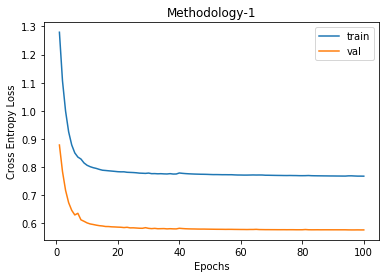

In [293]:
epoch = np.arange(1, 101)
plt.plot(epoch, history_s1)
plt.plot(epoch, dev_history_s1)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Methodology-1')
plt.legend(['train', 'val'])
plt.show()

In [289]:
with open('dev_history_s2.txt', 'wb') as h:
    pickle.dump(str(dev_history_s2), h)

# Visualizing the results 

In [205]:
k = 112
a = test[k]
inp = torch.from_numpy(inputs[a])
inp = inp.permute(2, 0, 1)
inp = torch.unsqueeze(inp, 0).to(device)
outputs = unet_s1(inp.float())
outputs = torch.argmax(outputs, dim = 1).cpu()
outputs = torch.squeeze(outputs, 0)
output = F.one_hot(outputs, num_classes = 4)

In [206]:
label = labels_s1[a]
out = np.zeros((300, 300, 4))
for i in range(label.shape[0]):
  for j in range(label.shape[1]):
    if label[i][j] == 0:
      out[i][j][0] = 1
    elif label[i][j] == 1:
      out[i][j][1] = 1
    if label[i][j] == 2:
      out[i][j][2] = 1
    if label[i][j] == 3:
      out[i][j][3] = 1

Text(0.5, 1.0, 'Input Image')

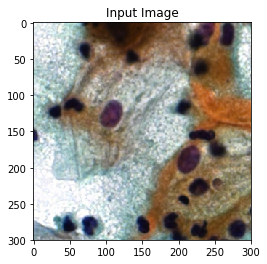

In [207]:
plt.imshow(inputs[a])
plt.title('Input Image')

Text(0.5, 1.0, 'Background (Ground Truth)')

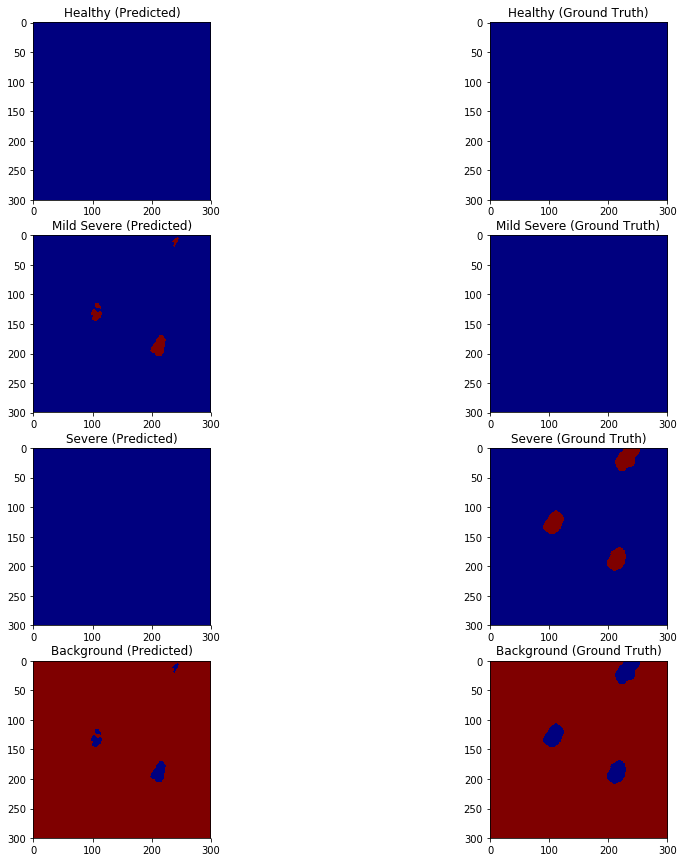

In [208]:
h, m, s, b = cv2.split(np.array(output))
h1, m1, s1, b1 = cv2.split(np.array(out))
f, ax = plt.subplots(4, 2, figsize = (15, 15))
ax[0, 0].imshow(h, cmap = 'jet')
ax[0, 0].set_title('Healthy (Predicted)')
ax[0, 1].imshow(h1, cmap = 'jet')
ax[0, 1].set_title('Healthy (Ground Truth)')

ax[1, 0].imshow(m, cmap = 'jet')
ax[1, 0].set_title('Mild Severe (Predicted)')
ax[1, 1].imshow(m1, cmap = 'jet')
ax[1, 1].set_title('Mild Severe (Ground Truth)')

ax[2, 0].imshow(s, cmap = 'jet')
ax[2, 0].set_title('Severe (Predicted)')
ax[2, 1].imshow(s1, cmap = 'jet')
ax[2, 1].set_title('Severe (Ground Truth)')

ax[3, 0].imshow(b, cmap = 'jet')
ax[3, 0].set_title('Background (Predicted)')
ax[3, 1].imshow(b1, cmap = 'jet')
ax[3, 1].set_title('Background (Ground Truth)')

# Setting - 2

In [38]:
# # Create targets

# files = glob.glob('/home/vinayak/RnD/Cervix/CI_Segmentation-s2/*')
# c = 0
# for file in files:
#     c += 1
#     print(c)
#     name = file.split('/')[-1].split('.')[0]
#     img = cv2.imread(file)
#     img = np.array(img)
#     out = np.zeros((img.shape[0], img.shape[1]))
#     for i in range(img.shape[0]):
#             for j in range(img.shape[1]):
#                 # Red
#                 if img[i][j][0] == 255 and img[i][j][1] == 0 and img[i][j][2] == 0:
#                     out[i][j] = 1

#                 # Green
#                 elif img[i][j][0] == 0 and img[i][j][1] == 128 and img[i][j][2] == 0:
#                     out[i][j] = 0

#                 # Purple
#                 elif img[i][j][0] == 128 and img[i][j][1] == 0 and img[i][j][2] == 128:
#                     out[i][j] = 1

#                 # Brown
#                 elif img[i][j][0] == 51 and img[i][j][1] == 64 and img[i][j][2] == 92:
#                     out[i][j] = 2

#                 # Pink
#                 elif img[i][j][0] == 203 and img[i][j][1] == 192 and img[i][j][2] == 255:
#                     out[i][j] = 2

#                 # Gray
#                 elif img[i][j][0] == 169 and img[i][j][1] == 169 and img[i][j][2] == 169:
#                     out[i][j] = 2
                    
#                 else:
#                     out[i][j] = 3

#     os.chdir('/home/vinayak/RnD/Cervix/s1-target/')
#     out = np.array(out)
#     np.save(name, out)
#     os.chdir('/home/vinayak/RnD/Cervix/')

In [39]:
# input_img = glob.glob('Cropped Images/*')
# inputs = []
# labels_s2 = []
# c = 0
# for i in input_img:
#     c += 1
#     print(c)
#     name = i.split('/')[-1].split('.')[0]
#     img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
#     inputs.append(img)
#     lab = np.load('s2-target/' + name + '.npy')
#     labels_s2.append(lab)

In [40]:
# labels_s2 = np.array(labels_s2)
# inputs = np.array(inputs)

In [41]:
# np.save('label-s2', labels_s2)

In [56]:
labels_s2 = np.load('label-s2.npy')

In [57]:
sample = np.load('sample.npy')
train = sample[:608]
val = sample[608:800]
test = sample[800:]

In [74]:
criterion = torch.nn.CrossEntropyLoss()
unet_s2 = UNet(in_channel = 3, out_channel = 4)
optimizer = torch.optim.SGD(unet_s2.parameters(), lr = 0.01, momentum = 0.9)
unet_s2 = nn.DataParallel(unet_s2)
unet_s2.to("cuda")

DataParallel(
  (module): UNet(
    (conv_encode1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode

In [75]:
epochs = 100
batch_size = 16
total_batches = train.shape[0] // batch_size

history_s2 = []
dev_history_s2 = []
device = "cuda"

for k in range(1, epochs + 1):
    total_loss = 0
    dev_total_loss = 0
    c = 0
    for i in tqdm(range(1, total_batches + 1), "Epoch is running :"):
      
      optimizer.zero_grad()    
      # Creating input and label for both training and validation set
      inp = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
      label = np.zeros((batch_size, labels_s2.shape[1], labels_s2.shape[2]))
      for b in range(batch_size):
            inp[b] = inputs[train[c]]
            label[b] = labels_s2[train[c]]
            c += 1
            
      inp = torch.from_numpy(inp)
      inp = inp.permute(0, 3, 1, 2).float().to(device)
      label = torch.from_numpy(label)
        
      # Generating outputs  
      outputs = unet_s2(inp)
    
      # outputs = torch.argmax(outputs, dim = 1)
      # outputs = F.one_hot(outputs, num_classes = 4)
    
      outputs = outputs.float().to(device)
      label = label.type(torch.LongTensor).to(device)
        
      # Calculating loss
      loss = criterion(outputs, label)
    
      total_loss += float(loss.item())
        
      loss.backward()
      optimizer.step()
        
    total_loss /= total_batches
    
    history_s2.append(total_loss)
    
    # Calculate validation loss
    c1 = 0
    total_dev_loss = 0
    for v in range(1, val.shape[0] // batch_size + 1):
        dev_input = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
        dev_label = np.zeros((batch_size, labels_s2.shape[1], labels_s2.shape[2]))
        for b in range(batch_size):
            dev_input[b] = inputs[val[c1]]
            dev_label[b] = labels_s2[val[c1]]
            c1 += 1
            
        dev_input = torch.from_numpy(dev_input)
        dev_input = dev_input.permute(0, 3, 1, 2).float().to(device)
        dev_label = torch.from_numpy(dev_label)
        
        dev_output = unet_s2(dev_input)
        dev_output = dev_output.float().to(device)
        dev_label = dev_label.type(torch.LongTensor).to(device)
        
        dev_loss = criterion(dev_output, dev_label)
    
        total_dev_loss += float(dev_loss.item())
    
    total_dev_loss /= batch_size
    dev_history_s2.append(total_dev_loss)
    
    # Print details
    print('Epoch : ' + str(k) +  ' / ' + str(epochs) + ', Loss : ' + str(total_loss)
         + ', Validation Loss : ' + str(total_dev_loss))

Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.67it/s]

Epoch : 1 / 100, Loss : 1.2923138204373812, Validation Loss : 0.9251109436154366


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.60it/s]

Epoch : 2 / 100, Loss : 1.1879373977058811, Validation Loss : 0.8734458833932877


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.70it/s]

Epoch : 3 / 100, Loss : 1.1397425124519749, Validation Loss : 0.8490374386310577


Epoch is running ::   3%|▎         | 1/38 [00:00<00:07,  5.08it/s]

Epoch : 4 / 100, Loss : 1.1142833985780414, Validation Loss : 0.8372743129730225


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.15it/s]

Epoch : 5 / 100, Loss : 1.0986142033024837, Validation Loss : 0.8264096230268478


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.53it/s]

Epoch : 6 / 100, Loss : 1.0863777022612722, Validation Loss : 0.8192292526364326


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 7 / 100, Loss : 1.076567248294228, Validation Loss : 0.8143065944314003


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.54it/s]

Epoch : 8 / 100, Loss : 1.069535704035508, Validation Loss : 0.8096179589629173


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.62it/s]

Epoch : 9 / 100, Loss : 1.06221468197672, Validation Loss : 0.8054138794541359


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.18it/s]

Epoch : 10 / 100, Loss : 1.057108273631648, Validation Loss : 0.8034183531999588


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.48it/s]

Epoch : 11 / 100, Loss : 1.0528284405407153, Validation Loss : 0.7981148213148117


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.96it/s]

Epoch : 12 / 100, Loss : 1.0476320354562056, Validation Loss : 0.796586275100708


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.77it/s]

Epoch : 13 / 100, Loss : 1.0445823292983205, Validation Loss : 0.7949990034103394


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.54it/s]

Epoch : 14 / 100, Loss : 1.042050639265462, Validation Loss : 0.7943304777145386


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.16it/s]

Epoch : 15 / 100, Loss : 1.0401457689310376, Validation Loss : 0.7934427037835121


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.28it/s]

Epoch : 16 / 100, Loss : 1.0383121700663316, Validation Loss : 0.7926334738731384


Epoch is running ::   3%|▎         | 1/38 [00:00<00:07,  5.04it/s]

Epoch : 17 / 100, Loss : 1.0361297867800061, Validation Loss : 0.7920913025736809


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.45it/s]

Epoch : 18 / 100, Loss : 1.0345710766942877, Validation Loss : 0.792158916592598


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.39it/s]

Epoch : 19 / 100, Loss : 1.0332906246185303, Validation Loss : 0.791457898914814


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.59it/s]

Epoch : 20 / 100, Loss : 1.0319831386992806, Validation Loss : 0.7906301915645599


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.71it/s]

Epoch : 21 / 100, Loss : 1.0303864463379508, Validation Loss : 0.7898352593183517


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.74it/s]

Epoch : 22 / 100, Loss : 1.028898166982751, Validation Loss : 0.7886755913496017


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.63it/s]

Epoch : 23 / 100, Loss : 1.027319139555881, Validation Loss : 0.7878657355904579


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.29it/s]

Epoch : 24 / 100, Loss : 1.025625024971209, Validation Loss : 0.7869205623865128


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.45it/s]

Epoch : 25 / 100, Loss : 1.023466933714716, Validation Loss : 0.7869328483939171


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.00it/s]

Epoch : 26 / 100, Loss : 1.022679510869478, Validation Loss : 0.7865175157785416


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 27 / 100, Loss : 1.0219223201274872, Validation Loss : 0.7877645194530487


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.29it/s]

Epoch : 28 / 100, Loss : 1.0205459704524593, Validation Loss : 0.786256205290556


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.59it/s]

Epoch : 29 / 100, Loss : 1.0180672156183344, Validation Loss : 0.7849147468805313


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.52it/s]

Epoch : 30 / 100, Loss : 1.0169128618742291, Validation Loss : 0.7830839902162552


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.23it/s]

Epoch : 31 / 100, Loss : 1.0161894308893304, Validation Loss : 0.7839044854044914


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.97it/s]

Epoch : 32 / 100, Loss : 1.0161626966376054, Validation Loss : 0.7827507480978966


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.71it/s]

Epoch : 33 / 100, Loss : 1.0173473028760207, Validation Loss : 0.786509282886982


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.57it/s]

Epoch : 34 / 100, Loss : 1.0143358252550427, Validation Loss : 0.7818589098751545


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.43it/s]

Epoch : 35 / 100, Loss : 1.009769165202191, Validation Loss : 0.7799853459000587


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.80it/s]

Epoch : 36 / 100, Loss : 1.0078041177046926, Validation Loss : 0.7807924598455429


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 37 / 100, Loss : 1.0073289526136298, Validation Loss : 0.7822804972529411


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.52it/s]

Epoch : 38 / 100, Loss : 1.0090767066729696, Validation Loss : 0.7814540900290012


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.25it/s]

Epoch : 39 / 100, Loss : 1.007365473006901, Validation Loss : 0.7791453041136265


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.31it/s]

Epoch : 40 / 100, Loss : 1.0030783932459981, Validation Loss : 0.7784872055053711


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.40it/s]

Epoch : 41 / 100, Loss : 1.002032916796835, Validation Loss : 0.778839498758316


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.56it/s]

Epoch : 42 / 100, Loss : 0.9994956364757136, Validation Loss : 0.776672188192606


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.51it/s]

Epoch : 43 / 100, Loss : 0.9976942978407207, Validation Loss : 0.776712853461504


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.88it/s]

Epoch : 44 / 100, Loss : 0.9975453395592538, Validation Loss : 0.7812914699316025


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.77it/s]

Epoch : 45 / 100, Loss : 1.0020452941718854, Validation Loss : 0.7742216475307941


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.38it/s]

Epoch : 46 / 100, Loss : 0.99904665350914, Validation Loss : 0.7846964672207832


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 47 / 100, Loss : 1.0162484802697833, Validation Loss : 0.77870849147439


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.36it/s]

Epoch : 48 / 100, Loss : 1.0015561957108348, Validation Loss : 0.7739807926118374


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.43it/s]

Epoch : 49 / 100, Loss : 0.998182834763276, Validation Loss : 0.776634693145752


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.70it/s]

Epoch : 50 / 100, Loss : 0.9992874264717102, Validation Loss : 0.7706732042133808


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.45it/s]

Epoch : 51 / 100, Loss : 1.0021552914067318, Validation Loss : 0.7739065513014793


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.27it/s]

Epoch : 52 / 100, Loss : 0.9992074605665708, Validation Loss : 0.7704282477498055


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.28it/s]

Epoch : 53 / 100, Loss : 0.9924196616599434, Validation Loss : 0.7681616768240929


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.25it/s]

Epoch : 54 / 100, Loss : 0.9914425564439673, Validation Loss : 0.7698314636945724


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.64it/s]

Epoch : 55 / 100, Loss : 0.9884894254960512, Validation Loss : 0.7725096307694912


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.26it/s]

Epoch : 56 / 100, Loss : 0.9855800349461404, Validation Loss : 0.7713638916611671


Epoch is running ::   3%|▎         | 1/38 [00:00<00:07,  5.05it/s]

Epoch : 57 / 100, Loss : 0.9843343590435228, Validation Loss : 0.7723302766680717


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.59it/s]

Epoch : 58 / 100, Loss : 0.9833162066183592, Validation Loss : 0.7720825672149658


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.58it/s]

Epoch : 59 / 100, Loss : 0.9815281896214736, Validation Loss : 0.7749124206602573


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.79it/s]

Epoch : 60 / 100, Loss : 0.9787310001097227, Validation Loss : 0.771245401352644


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.41it/s]

Epoch : 61 / 100, Loss : 0.9768963958087721, Validation Loss : 0.7745133750140667


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.72it/s]

Epoch : 62 / 100, Loss : 0.9740740264716902, Validation Loss : 0.7716395780444145


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.69it/s]

Epoch : 63 / 100, Loss : 0.9718708678295738, Validation Loss : 0.7740250825881958


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.44it/s]

Epoch : 64 / 100, Loss : 0.9701169603749326, Validation Loss : 0.7735110931098461


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.43it/s]

Epoch : 65 / 100, Loss : 0.970280176714847, Validation Loss : 0.7724155336618423


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.42it/s]

Epoch : 66 / 100, Loss : 0.9716906375006625, Validation Loss : 0.7684422433376312


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 67 / 100, Loss : 0.9717338822389904, Validation Loss : 0.768835972994566


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.56it/s]

Epoch : 68 / 100, Loss : 0.9723190367221832, Validation Loss : 0.7665584161877632


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.63it/s]

Epoch : 69 / 100, Loss : 0.9734465715132261, Validation Loss : 0.7693705298006535


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.47it/s]

Epoch : 70 / 100, Loss : 0.9756165586019817, Validation Loss : 0.7784154079854488


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.40it/s]

Epoch : 71 / 100, Loss : 0.9770554304122925, Validation Loss : 0.7642604224383831


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.44it/s]

Epoch : 72 / 100, Loss : 0.9676084894883005, Validation Loss : 0.7627474516630173


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.36it/s]

Epoch : 73 / 100, Loss : 0.9653033520046034, Validation Loss : 0.76416926831007


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.18it/s]

Epoch : 74 / 100, Loss : 0.9660326226761466, Validation Loss : 0.7689086720347404


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.63it/s]

Epoch : 75 / 100, Loss : 0.9690431874049338, Validation Loss : 0.7711156830191612


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.16it/s]

Epoch : 76 / 100, Loss : 0.9655919467148028, Validation Loss : 0.779256071895361


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 77 / 100, Loss : 0.9635513754267442, Validation Loss : 0.7748167812824249


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.15it/s]

Epoch : 78 / 100, Loss : 0.9628120472556666, Validation Loss : 0.7744825221598148


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.69it/s]

Epoch : 79 / 100, Loss : 0.9623457460026992, Validation Loss : 0.7629947736859322


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.89it/s]

Epoch : 80 / 100, Loss : 0.9576309417423449, Validation Loss : 0.7663911432027817


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.53it/s]

Epoch : 81 / 100, Loss : 0.9551641486193004, Validation Loss : 0.770553708076477


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.57it/s]

Epoch : 82 / 100, Loss : 0.9540624304821617, Validation Loss : 0.7680703885853291


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.75it/s]

Epoch : 83 / 100, Loss : 0.9553180964369523, Validation Loss : 0.7690891064703465


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.66it/s]

Epoch : 84 / 100, Loss : 0.952915337524916, Validation Loss : 0.7679010480642319


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.88it/s]

Epoch : 85 / 100, Loss : 0.9524859629179302, Validation Loss : 0.7687223218381405


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.65it/s]

Epoch : 86 / 100, Loss : 0.9509629701313219, Validation Loss : 0.7688929215073586


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 87 / 100, Loss : 0.9520388276953446, Validation Loss : 0.7732686959207058


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.76it/s]

Epoch : 88 / 100, Loss : 0.9482539735342327, Validation Loss : 0.7661775685846806


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.64it/s]

Epoch : 89 / 100, Loss : 0.9497162997722626, Validation Loss : 0.7638546600937843


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.17it/s]

Epoch : 90 / 100, Loss : 0.9512528651639035, Validation Loss : 0.7619496919214725


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.28it/s]

Epoch : 91 / 100, Loss : 0.9532854745262548, Validation Loss : 0.7726949080824852


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.87it/s]

Epoch : 92 / 100, Loss : 0.9531004962168241, Validation Loss : 0.76227767765522


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.60it/s]

Epoch : 93 / 100, Loss : 0.9476022688966048, Validation Loss : 0.7632618732750416


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.16it/s]

Epoch : 94 / 100, Loss : 0.949661479184502, Validation Loss : 0.7637004628777504


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.31it/s]

Epoch : 95 / 100, Loss : 0.9502998119906375, Validation Loss : 0.7640387378633022


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.94it/s]

Epoch : 96 / 100, Loss : 0.9469360630763205, Validation Loss : 0.7701436504721642


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 97 / 100, Loss : 0.9481091216990822, Validation Loss : 0.7648795172572136


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.15it/s]

Epoch : 98 / 100, Loss : 0.9460936455350173, Validation Loss : 0.7701375745236874


Epoch is running ::   3%|▎         | 1/38 [00:00<00:04,  7.66it/s]

Epoch : 99 / 100, Loss : 0.9444801713290968, Validation Loss : 0.7753471657633781


Epoch is running :: 100%|██████████| 38/38 [00:07<00:00,  4.91it/s]


Epoch : 100 / 100, Loss : 0.9481549247315055, Validation Loss : 0.7683429419994354


In [210]:
h = []
for i in dev_history_s2:
    h.append(i * 16)
dev_history_s2 = h

In [209]:
# Saving the model
torch.save(unet_s2.module.state_dict(), 'unet-s2')

In [48]:
# # Loading the model
# device = torch.device("cuda")
# unet_s2 = UNet(in_channel = 3, out_channel = 4)
# unet_s2.load_state_dict(torch.load('unet-s2'))
# unet_s2.to(device)

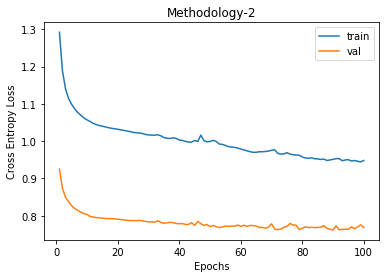

In [294]:
epoch = np.arange(1, 101)
plt.plot(epoch, history_s2)
plt.plot(epoch, dev_history_s2)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Methodology-2')
plt.legend(['train', 'val'])
plt.show()

In [249]:
k = 112
a = test[k]
inp = torch.from_numpy(inputs[a])
inp = inp.permute(2, 0, 1)
inp = torch.unsqueeze(inp, 0).to(device)
outputs = unet_s2(inp.float())
outputs = torch.argmax(outputs, dim = 1).cpu()
outputs = torch.squeeze(outputs, 0)
output = F.one_hot(outputs, num_classes = 4)

In [250]:
label = labels_s2[a]
out = np.zeros((300, 300, 4))
for i in range(label.shape[0]):
  for j in range(label.shape[1]):
    if label[i][j] == 0:
      out[i][j][0] = 1
    elif label[i][j] == 1:
      out[i][j][1] = 1
    if label[i][j] == 2:
      out[i][j][2] = 1
    if label[i][j] == 3:
      out[i][j][3] = 1

Text(0.5, 1.0, 'Input Image')

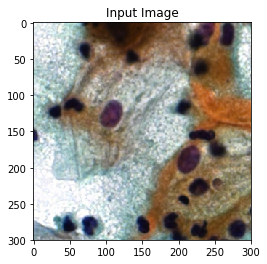

In [251]:
plt.imshow(inputs[a])
plt.title('Input Image')

Text(0.5, 1.0, 'Background (Ground Truth)')

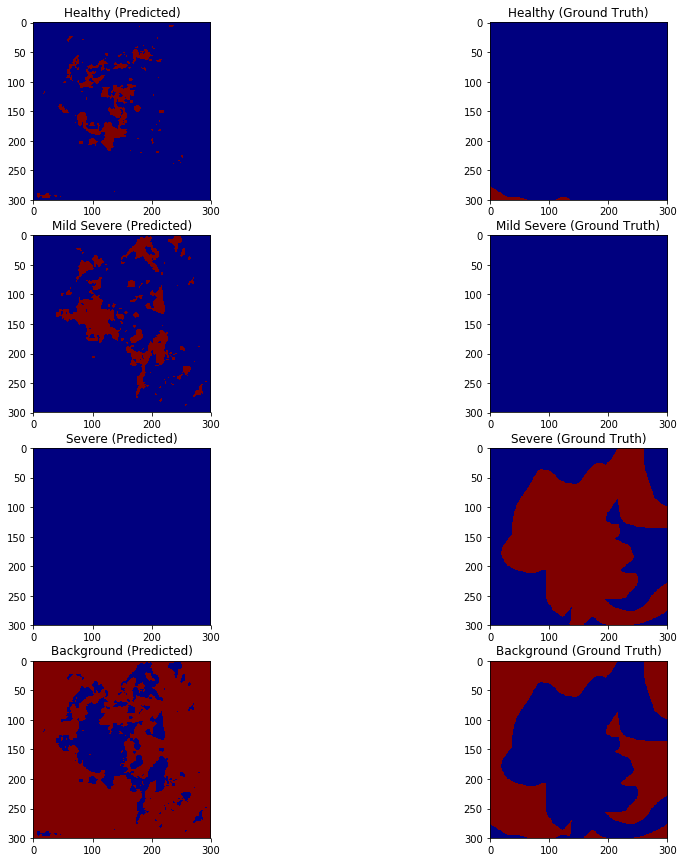

In [252]:
h, m, s, b = cv2.split(np.array(output))
h1, m1, s1, b1 = cv2.split(np.array(out))
f, ax = plt.subplots(4, 2, figsize = (15, 15))
ax[0, 0].imshow(h, cmap = 'jet')
ax[0, 0].set_title('Healthy (Predicted)')
ax[0, 1].imshow(h1, cmap = 'jet')
ax[0, 1].set_title('Healthy (Ground Truth)')

ax[1, 0].imshow(m, cmap = 'jet')
ax[1, 0].set_title('Mild Severe (Predicted)')
ax[1, 1].imshow(m1, cmap = 'jet')
ax[1, 1].set_title('Mild Severe (Ground Truth)')

ax[2, 0].imshow(s, cmap = 'jet')
ax[2, 0].set_title('Severe (Predicted)')
ax[2, 1].imshow(s1, cmap = 'jet')
ax[2, 1].set_title('Severe (Ground Truth)')

ax[3, 0].imshow(b, cmap = 'jet')
ax[3, 0].set_title('Background (Predicted)')
ax[3, 1].imshow(b1, cmap = 'jet')
ax[3, 1].set_title('Background (Ground Truth)')

# Setting - 3

In [3]:
# input_img = glob.glob('Cropped Images/*')
# inputs = []
# labels_s3 = []
# c = 0
# for i in input_img:
#     c += 1
#     print(c)
#     name = i.split('/')[-1].split('.')[0]
#     img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
#     inputs.append(img)
#     lab = np.load('s3-target/' + name + '.npy')
#     labels_s3.append(lab)

In [4]:
# labels_s3 = np.array(labels_s3)
# inputs = np.array(inputs)

In [5]:
# np.save('label-s3', labels_s3)

In [61]:
labels_s3 = np.load('label-s3.npy')

In [7]:
# n = inputs.shape[0]
# sample = random.sample(range(0, n), n)

In [62]:
sample = np.load('sample.npy')
train = sample[:608]
val = sample[608:800]
test = sample[800:]

In [76]:
criterion = torch.nn.CrossEntropyLoss()
unet_s3 = UNet(in_channel = 3, out_channel = 5)
optimizer = torch.optim.SGD(unet_s3.parameters(), lr = 0.01, momentum = 0.9)
unet_s3 = nn.DataParallel(unet_s3)
unet_s3.to("cuda")

DataParallel(
  (module): UNet(
    (conv_encode1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode

In [77]:
epochs = 100
batch_size = 16
total_batches = train.shape[0] // batch_size

history_s3 = []
dev_history_s3 = []
device = "cuda"

for k in range(1, epochs + 1):
    total_loss = 0
    dev_total_loss = 0
    c = 0
    for i in tqdm(range(1, total_batches + 1), "Epoch is running :"):
      
      optimizer.zero_grad()    
      # Creating input and label for both training and validation set
      inp = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
      label = np.zeros((batch_size, labels_s3.shape[1], labels_s3.shape[2]))
      for b in range(batch_size):
            inp[b] = inputs[train[c]]
            label[b] = labels_s3[train[c]]
            c += 1
            
      inp = torch.from_numpy(inp)
      inp = inp.permute(0, 3, 1, 2).float().to(device)
      label = torch.from_numpy(label)
        
      # Generating outputs  
      outputs = unet_s3(inp)
    
      # outputs = torch.argmax(outputs, dim = 1)
      # outputs = F.one_hot(outputs, num_classes = 4)
    
      outputs = outputs.float().to(device)
      label = label.type(torch.LongTensor).to(device)
        
      # Calculating loss
      loss = criterion(outputs, label)
    
      total_loss += float(loss.item())
        
      loss.backward()
      optimizer.step()
        
    total_loss /= total_batches
    
    history_s3.append(total_loss)
    
    # Calculate validation loss
    c1 = 0
    total_dev_loss = 0
    for v in range(1, val.shape[0] // batch_size + 1):
        dev_input = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
        dev_label = np.zeros((batch_size, labels_s3.shape[1], labels_s3.shape[2]))
        for b in range(batch_size):
            dev_input[b] = inputs[val[c1]]
            dev_label[b] = labels_s3[val[c1]]
            c1 += 1
            
        dev_input = torch.from_numpy(dev_input)
        dev_input = dev_input.permute(0, 3, 1, 2).float().to(device)
        dev_label = torch.from_numpy(dev_label)
        
        dev_output = unet_s3(dev_input)
        dev_output = dev_output.float().to(device)
        dev_label = dev_label.type(torch.LongTensor).to(device)
        
        dev_loss = criterion(dev_output, dev_label)
    
        total_dev_loss += float(dev_loss.item())
    
    total_dev_loss /= batch_size
    dev_history_s3.append(total_dev_loss / batch_size)
    
    # Print details
    print('Epoch : ' + str(k) +  ' / ' + str(epochs) + ', Loss : ' + str(total_loss)
         + ', Validation Loss : ' + str(total_dev_loss))

Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.40it/s]

Epoch : 1 / 100, Loss : 1.4696830166013617, Validation Loss : 1.0409179329872131


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.08it/s]

Epoch : 2 / 100, Loss : 1.3419360361601178, Validation Loss : 0.9828787818551064


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.66it/s]

Epoch : 3 / 100, Loss : 1.2803780436515808, Validation Loss : 0.9460818469524384


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.46it/s]

Epoch : 4 / 100, Loss : 1.2411902703736957, Validation Loss : 0.9233082309365273


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.50it/s]

Epoch : 5 / 100, Loss : 1.2144985606795864, Validation Loss : 0.9063418358564377


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.98it/s]

Epoch : 6 / 100, Loss : 1.1954469367077476, Validation Loss : 0.897047609090805


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.29it/s]

Epoch : 7 / 100, Loss : 1.183639485585062, Validation Loss : 0.8889037072658539


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.63it/s]

Epoch : 8 / 100, Loss : 1.1740448380771435, Validation Loss : 0.8830200508236885


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 9 / 100, Loss : 1.166879377867046, Validation Loss : 0.8783301189541817


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.02it/s]

Epoch : 10 / 100, Loss : 1.1601596098197133, Validation Loss : 0.874539315700531


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.10it/s]

Epoch : 11 / 100, Loss : 1.156244983798579, Validation Loss : 0.8726758435368538


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.57it/s]

Epoch : 12 / 100, Loss : 1.1518504870565314, Validation Loss : 0.8691729456186295


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.40it/s]

Epoch : 13 / 100, Loss : 1.1487273166054173, Validation Loss : 0.8667117059230804


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.48it/s]

Epoch : 14 / 100, Loss : 1.1445654254210622, Validation Loss : 0.8636686950922012


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.69it/s]

Epoch : 15 / 100, Loss : 1.1426395115099455, Validation Loss : 0.8625504150986671


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.03it/s]

Epoch : 16 / 100, Loss : 1.139829695224762, Validation Loss : 0.8602002412080765


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.18it/s]

Epoch : 17 / 100, Loss : 1.1373787647799443, Validation Loss : 0.8598762005567551


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.44it/s]

Epoch : 18 / 100, Loss : 1.1357333409158807, Validation Loss : 0.8580563887953758


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 19 / 100, Loss : 1.1335707275491012, Validation Loss : 0.8575495108962059


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.98it/s]

Epoch : 20 / 100, Loss : 1.131564698721233, Validation Loss : 0.8560618385672569


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.57it/s]

Epoch : 21 / 100, Loss : 1.130668536612862, Validation Loss : 0.855653703212738


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.01it/s]

Epoch : 22 / 100, Loss : 1.1300149214895148, Validation Loss : 0.855055421590805


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.97it/s]

Epoch : 23 / 100, Loss : 1.1268672001989264, Validation Loss : 0.8546724691987038


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.76it/s]

Epoch : 24 / 100, Loss : 1.1272479327101457, Validation Loss : 0.8515305668115616


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.01it/s]

Epoch : 25 / 100, Loss : 1.1250821257892407, Validation Loss : 0.8524199575185776


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.63it/s]

Epoch : 26 / 100, Loss : 1.1248900670754283, Validation Loss : 0.8505831137299538


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.18it/s]

Epoch : 27 / 100, Loss : 1.1219651259874042, Validation Loss : 0.8510794565081596


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.77it/s]

Epoch : 28 / 100, Loss : 1.1207668655797054, Validation Loss : 0.8502851873636246


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 29 / 100, Loss : 1.1207104670374017, Validation Loss : 0.849934846162796


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.14it/s]

Epoch : 30 / 100, Loss : 1.1179927116946171, Validation Loss : 0.8503005653619766


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.98it/s]

Epoch : 31 / 100, Loss : 1.1186689169783341, Validation Loss : 0.848592609167099


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.59it/s]

Epoch : 32 / 100, Loss : 1.116101418670855, Validation Loss : 0.8483610600233078


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.94it/s]

Epoch : 33 / 100, Loss : 1.1147705191060115, Validation Loss : 0.849170632660389


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.85it/s]

Epoch : 34 / 100, Loss : 1.1136294195526524, Validation Loss : 0.8481064662337303


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.17it/s]

Epoch : 35 / 100, Loss : 1.1125686513750177, Validation Loss : 0.846839465200901


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.68it/s]

Epoch : 36 / 100, Loss : 1.111074541744433, Validation Loss : 0.8460959270596504


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.49it/s]

Epoch : 37 / 100, Loss : 1.1103584985983999, Validation Loss : 0.8467472940683365


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.62it/s]

Epoch : 38 / 100, Loss : 1.1098225430438393, Validation Loss : 0.84579236805439


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 39 / 100, Loss : 1.1085005026114614, Validation Loss : 0.8457963094115257


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.97it/s]

Epoch : 40 / 100, Loss : 1.107018348417784, Validation Loss : 0.8455969169735909


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.60it/s]

Epoch : 41 / 100, Loss : 1.1058725400974876, Validation Loss : 0.8462422788143158


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.08it/s]

Epoch : 42 / 100, Loss : 1.1055906916919507, Validation Loss : 0.8466073423624039


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.59it/s]

Epoch : 43 / 100, Loss : 1.1050997313700224, Validation Loss : 0.8497141450643539


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.25it/s]

Epoch : 44 / 100, Loss : 1.1078305652267055, Validation Loss : 0.8468347936868668


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.99it/s]

Epoch : 45 / 100, Loss : 1.1066904036622298, Validation Loss : 0.8496620580554008


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.12it/s]

Epoch : 46 / 100, Loss : 1.1095527755586725, Validation Loss : 0.8461725860834122


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.83it/s]

Epoch : 47 / 100, Loss : 1.106326134581315, Validation Loss : 0.8444440066814423


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.77it/s]

Epoch : 48 / 100, Loss : 1.1043456573235362, Validation Loss : 0.8451611250638962


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 49 / 100, Loss : 1.1039671364583468, Validation Loss : 0.8463523909449577


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.89it/s]

Epoch : 50 / 100, Loss : 1.1023250096722652, Validation Loss : 0.84316436201334


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.10it/s]

Epoch : 51 / 100, Loss : 1.1014992971169322, Validation Loss : 0.8448746800422668


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.97it/s]

Epoch : 52 / 100, Loss : 1.1011509393390857, Validation Loss : 0.8453229293227196


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.77it/s]

Epoch : 53 / 100, Loss : 1.1014669066981266, Validation Loss : 0.8449297174811363


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.52it/s]

Epoch : 54 / 100, Loss : 1.1007842045081289, Validation Loss : 0.8455595374107361


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.71it/s]

Epoch : 55 / 100, Loss : 1.0987510085105896, Validation Loss : 0.8445855975151062


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.91it/s]

Epoch : 56 / 100, Loss : 1.0963119142933895, Validation Loss : 0.8432484790682793


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.90it/s]

Epoch : 57 / 100, Loss : 1.0954045527859737, Validation Loss : 0.8448911681771278


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.05it/s]

Epoch : 58 / 100, Loss : 1.0948146330682855, Validation Loss : 0.8424431681632996


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 59 / 100, Loss : 1.0932973654646623, Validation Loss : 0.8424435704946518


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.75it/s]

Epoch : 60 / 100, Loss : 1.0929175740794133, Validation Loss : 0.8419850841164589


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.07it/s]

Epoch : 61 / 100, Loss : 1.0924282262199803, Validation Loss : 0.8417419046163559


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.29it/s]

Epoch : 62 / 100, Loss : 1.091785597173791, Validation Loss : 0.8414866849780083


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.15it/s]

Epoch : 63 / 100, Loss : 1.0917733719474392, Validation Loss : 0.8417553901672363


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.94it/s]

Epoch : 64 / 100, Loss : 1.0918420710061725, Validation Loss : 0.8398397862911224


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.95it/s]

Epoch : 65 / 100, Loss : 1.0899355035079152, Validation Loss : 0.8410441130399704


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.90it/s]

Epoch : 66 / 100, Loss : 1.088688351606068, Validation Loss : 0.8394954651594162


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.17it/s]

Epoch : 67 / 100, Loss : 1.089819349740681, Validation Loss : 0.838599257171154


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.25it/s]

Epoch : 68 / 100, Loss : 1.0873414058434336, Validation Loss : 0.8391861468553543


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 69 / 100, Loss : 1.0901569755453813, Validation Loss : 0.8404372408986092


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.09it/s]

Epoch : 70 / 100, Loss : 1.0935960537508915, Validation Loss : 0.836195208132267


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.10it/s]

Epoch : 71 / 100, Loss : 1.0906654690441333, Validation Loss : 0.8366267681121826


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.01it/s]

Epoch : 72 / 100, Loss : 1.086404053788436, Validation Loss : 0.8395369946956635


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.66it/s]

Epoch : 73 / 100, Loss : 1.0862610214634945, Validation Loss : 0.8396390974521637


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.90it/s]

Epoch : 74 / 100, Loss : 1.085374051018765, Validation Loss : 0.8391162008047104


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.93it/s]

Epoch : 75 / 100, Loss : 1.0845050278462862, Validation Loss : 0.8370297849178314


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.97it/s]

Epoch : 76 / 100, Loss : 1.0862082462561757, Validation Loss : 0.8381951972842216


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.02it/s]

Epoch : 77 / 100, Loss : 1.08710588593232, Validation Loss : 0.8362078443169594


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.75it/s]

Epoch : 78 / 100, Loss : 1.0845404988841008, Validation Loss : 0.8377698138356209


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 79 / 100, Loss : 1.0832278540259914, Validation Loss : 0.8373849540948868


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.68it/s]

Epoch : 80 / 100, Loss : 1.0821723749763088, Validation Loss : 0.8366968110203743


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.94it/s]

Epoch : 81 / 100, Loss : 1.0800548195838928, Validation Loss : 0.8356626108288765


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.89it/s]

Epoch : 82 / 100, Loss : 1.0794473478668614, Validation Loss : 0.8351046666502953


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.47it/s]

Epoch : 83 / 100, Loss : 1.0774936362316734, Validation Loss : 0.8353519812226295


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.93it/s]

Epoch : 84 / 100, Loss : 1.0789934710452431, Validation Loss : 0.8366712480783463


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.80it/s]

Epoch : 85 / 100, Loss : 1.0811075850536949, Validation Loss : 0.8387907966971397


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.94it/s]

Epoch : 86 / 100, Loss : 1.0757621118896885, Validation Loss : 0.8385285064578056


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.48it/s]

Epoch : 87 / 100, Loss : 1.0727815502568294, Validation Loss : 0.8409039676189423


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.99it/s]

Epoch : 88 / 100, Loss : 1.0718239765418203, Validation Loss : 0.8427084311842918


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 89 / 100, Loss : 1.0749671929760982, Validation Loss : 0.8378629237413406


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.90it/s]

Epoch : 90 / 100, Loss : 1.0752049213961552, Validation Loss : 0.838237076997757


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.79it/s]

Epoch : 91 / 100, Loss : 1.0680558116812455, Validation Loss : 0.8359912186861038


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.26it/s]

Epoch : 92 / 100, Loss : 1.0666759265096564, Validation Loss : 0.8437245339155197


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.04it/s]

Epoch : 93 / 100, Loss : 1.0677428716107418, Validation Loss : 0.8397084921598434


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.00it/s]

Epoch : 94 / 100, Loss : 1.0727138393803646, Validation Loss : 0.8355358392000198


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.08it/s]

Epoch : 95 / 100, Loss : 1.0753269603377895, Validation Loss : 0.8343996852636337


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.73it/s]

Epoch : 96 / 100, Loss : 1.0686390305820264, Validation Loss : 0.8349252417683601


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  6.44it/s]

Epoch : 97 / 100, Loss : 1.0635018976111161, Validation Loss : 0.838163785636425


Epoch is running ::   3%|▎         | 1/38 [00:00<00:05,  7.02it/s]

Epoch : 98 / 100, Loss : 1.061395497698533, Validation Loss : 0.8360960111021996


Epoch is running ::   0%|          | 0/38 [00:00<?, ?it/s]

Epoch : 99 / 100, Loss : 1.059523504031332, Validation Loss : 0.8407826721668243


Epoch is running :: 100%|██████████| 38/38 [00:07<00:00,  4.82it/s]


Epoch : 100 / 100, Loss : 1.0612433458629407, Validation Loss : 0.8408132046461105


In [253]:
# Saving the model
torch.save(unet_s3.module.state_dict(), 'unet-s3')

In [ ]:
# # Loading the model
# device = torch.device("cuda")
# unet_s3 = UNet(in_channel = 3, out_channel = 4)
# unet_s3.load_state_dict(torch.load('unet-s3'))
# unet_s3.to(device)

In [254]:
h = []
for i in dev_history_s3:
    h.append(i * 16)
dev_history_s3 = h

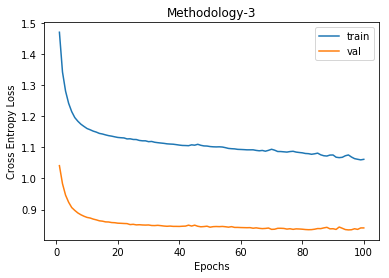

In [295]:
epoch = np.arange(1, 101)
plt.plot(epoch, history_s3)
plt.plot(epoch, dev_history_s3)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Methodology-3')
plt.legend(['train', 'val'])
plt.show()

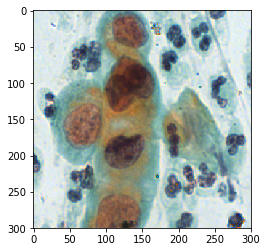

In [374]:
name = 'Image385_1'
a = np.array(cv2.cvtColor(cv2.imread('Cropped Images/'+ name +'.png'), cv2.COLOR_BGR2RGB))
label = np.load('s3-target/'+ name +'.npy')

inp = torch.from_numpy(a)
inp = inp.permute(2, 0, 1)
inp = torch.unsqueeze(inp, 0).to(device)
outputs = unet_s3(inp.float())
outputs = torch.argmax(outputs, dim = 1).cpu()
outputs = torch.squeeze(outputs, 0)
output = F.one_hot(outputs, num_classes = 5)

out = np.zeros((300, 300, 5))
for i in range(label.shape[0]):
  for j in range(label.shape[1]):
    if label[i][j] == 0:
      out[i][j][0] = 1
    elif label[i][j] == 1:
      out[i][j][1] = 1
    elif label[i][j] == 2:
      out[i][j][2] = 1
    elif label[i][j] == 3:
      out[i][j][3] = 1
    elif label[i][j] == 4:
      out[i][j][4] = 1
plt.imshow(a)

Text(0.5, 1.0, 'Background (Ground Truth)')

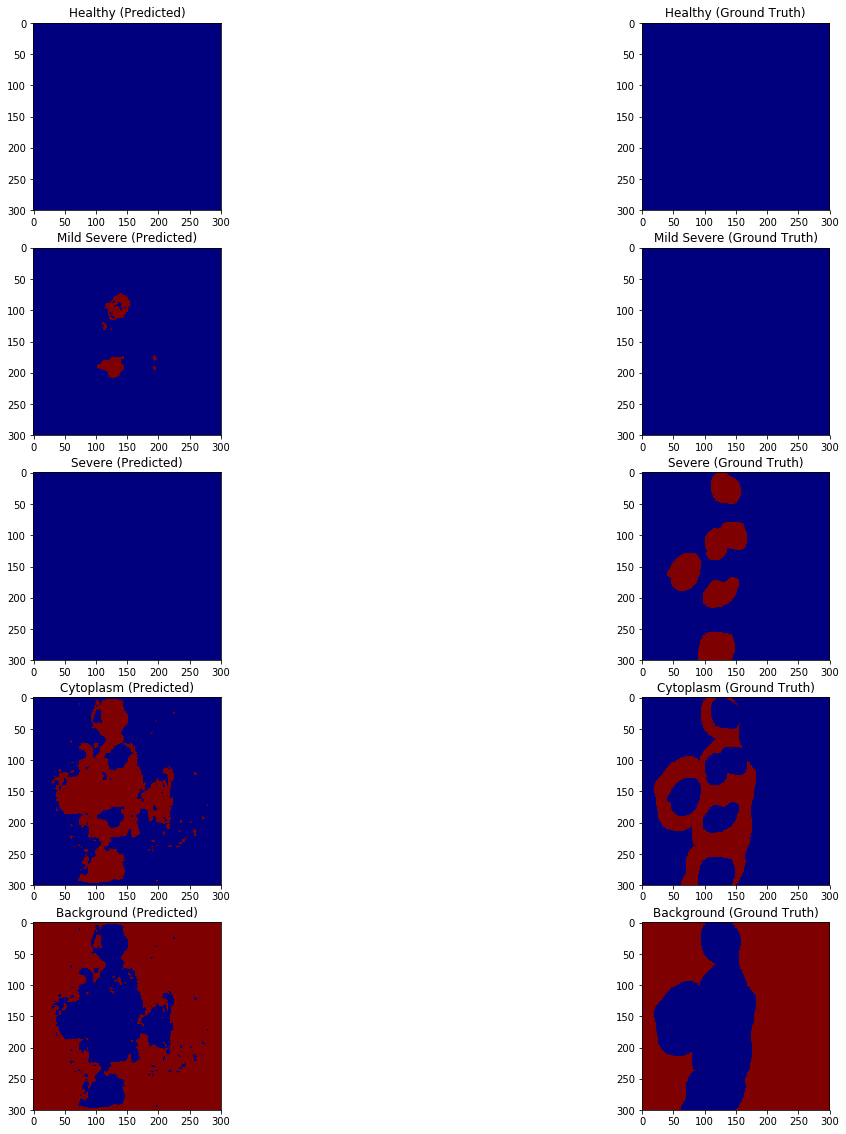

In [375]:
h, m, s, c, b = cv2.split(np.array(output))
h1, m1, s1, c1, b1 = cv2.split(np.array(out))
f, ax = plt.subplots(5, 2, figsize = (20, 20))
ax[0, 0].imshow(h, cmap = 'jet')
ax[0, 0].set_title('Healthy (Predicted)')
ax[0, 1].imshow(h1, cmap = 'jet')
ax[0, 1].set_title('Healthy (Ground Truth)')

ax[1, 0].imshow(m, cmap = 'jet')
ax[1, 0].set_title('Mild Severe (Predicted)')
ax[1, 1].imshow(m1, cmap = 'jet')
ax[1, 1].set_title('Mild Severe (Ground Truth)')

ax[2, 0].imshow(s, cmap = 'jet')
ax[2, 0].set_title('Severe (Predicted)')
ax[2, 1].imshow(s1, cmap = 'jet')
ax[2, 1].set_title('Severe (Ground Truth)')

ax[3, 0].imshow(c, cmap = 'jet')
ax[3, 0].set_title('Cytoplasm (Predicted)')
ax[3, 1].imshow(c1, cmap = 'jet')
ax[3, 1].set_title('Cytoplasm (Ground Truth)')

ax[4, 0].imshow(b, cmap = 'jet')
ax[4, 0].set_title('Background (Predicted)')
ax[4, 1].imshow(b1, cmap = 'jet')
ax[4, 1].set_title('Background (Ground Truth)')

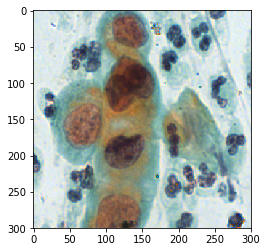

In [378]:
a = np.array(cv2.cvtColor(cv2.imread('Cropped Images/'+ name +'.png'), cv2.COLOR_BGR2RGB))
label = np.load('s1-target/'+ name +'.npy')

inp = torch.from_numpy(a)
inp = inp.permute(2, 0, 1)
inp = torch.unsqueeze(inp, 0).to(device)
outputs = unet_s1(inp.float())
outputs = torch.argmax(outputs, dim = 1).cpu()
outputs = torch.squeeze(outputs, 0)
output = F.one_hot(outputs, num_classes = 4)

out = np.zeros((300, 300, 4))
for i in range(label.shape[0]):
  for j in range(label.shape[1]):
    if label[i][j] == 0:
      out[i][j][0] = 1
    elif label[i][j] == 1:
      out[i][j][1] = 1
    elif label[i][j] == 2:
      out[i][j][2] = 1
    elif label[i][j] == 3:
      out[i][j][3] = 1
    
plt.imshow(a)

Text(0.5, 1.0, 'Background (Ground Truth)')

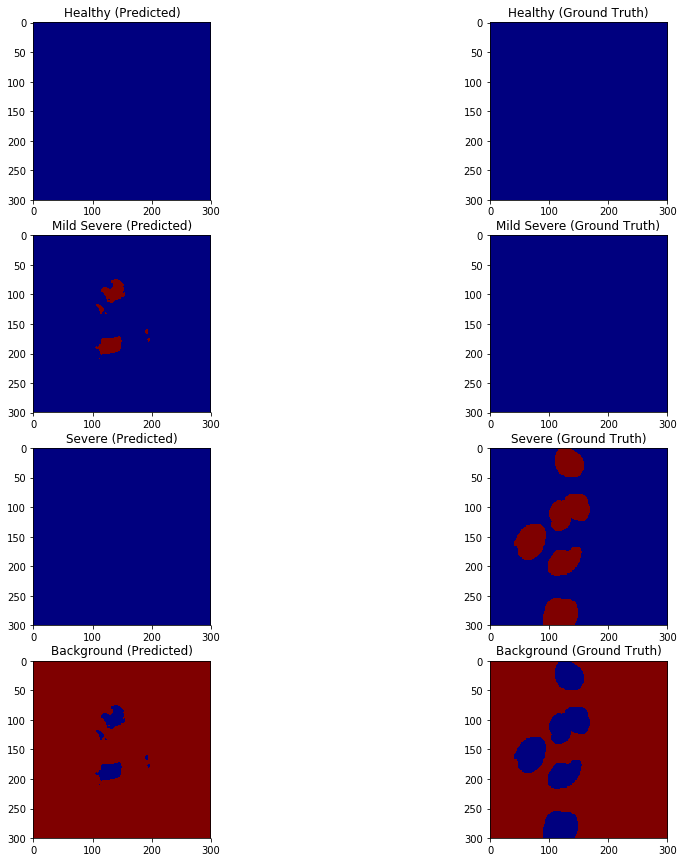

In [379]:
h, m, s, b = cv2.split(np.array(output))
h1, m1, s1, b1 = cv2.split(np.array(out))
f, ax = plt.subplots(4, 2, figsize = (15, 15))
ax[0, 0].imshow(h, cmap = 'jet')
ax[0, 0].set_title('Healthy (Predicted)')
ax[0, 1].imshow(h1, cmap = 'jet')
ax[0, 1].set_title('Healthy (Ground Truth)')

ax[1, 0].imshow(m, cmap = 'jet')
ax[1, 0].set_title('Mild Severe (Predicted)')
ax[1, 1].imshow(m1, cmap = 'jet')
ax[1, 1].set_title('Mild Severe (Ground Truth)')

ax[2, 0].imshow(s, cmap = 'jet')
ax[2, 0].set_title('Severe (Predicted)')
ax[2, 1].imshow(s1, cmap = 'jet')
ax[2, 1].set_title('Severe (Ground Truth)')

ax[3, 0].imshow(b, cmap = 'jet')
ax[3, 0].set_title('Background (Predicted)')
ax[3, 1].imshow(b1, cmap = 'jet')
ax[3, 1].set_title('Background (Ground Truth)')